# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [18:41<00:00, 54.2File/s]  


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

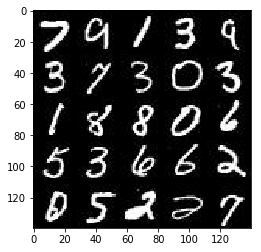

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

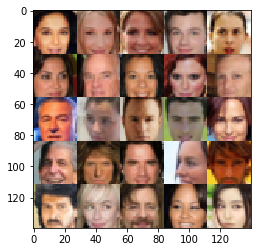

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    in_learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return input_real, input_z, in_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.1, stddev=0.02):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 1 in: 28x28x(1|3)
        layer_1 = tf.layers.conv2d(images, 32, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 14x14x32
        
        # Layer 2: 14x14x32
        layer_2 = tf.layers.conv2d(layer_1, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 7x7x64
        
        layer_3 = tf.layers.conv2d(layer_2, 128, 5, 2, padding='same',  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 4x4x128
        
        layer_4 = tf.layers.conv2d(layer_3, 256, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 2x2x256
        
        flattened = tf.reshape(layer_4, (-1, 2*2*256))
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, stddev=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 1 in: 7x7x256
        layer_1 = tf.layers.dense(z, 4 * 4 * 512)
        layer_1 = tf.reshape(layer_1, (-1, 4, 4, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 4x4x512
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 128, 4, 1, padding='valid', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 8x8x128
        
        layer_3 = tf.layers.conv2d_transpose(layer_2, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 16x16x64
        
        layer_4 = tf.layers.conv2d_transpose(layer_3, 32, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=is_train)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 32x32x32
        
        logits = tf.layers.conv2d_transpose(layer_4, out_channel_dim, 3, 1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                         "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8767... Generator Loss: 1.7685
Epoch 1/2... Discriminator Loss: 0.7807... Generator Loss: 2.0321
Epoch 1/2... Discriminator Loss: 1.2731... Generator Loss: 1.7757
Epoch 1/2... Discriminator Loss: 0.3844... Generator Loss: 3.4650
Epoch 1/2... Discriminator Loss: 0.5614... Generator Loss: 1.9878
Epoch 1/2... Discriminator Loss: 0.9012... Generator Loss: 1.0335
Epoch 1/2... Discriminator Loss: 0.9785... Generator Loss: 1.1962
Epoch 1/2... Discriminator Loss: 0.5054... Generator Loss: 2.1177
Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 0.9283
Epoch 1/2... Discriminator Loss: 0.8920... Generator Loss: 1.2100


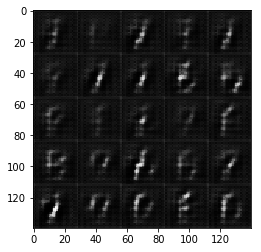

Epoch 1/2... Discriminator Loss: 0.9363... Generator Loss: 1.5998
Epoch 1/2... Discriminator Loss: 0.7282... Generator Loss: 1.9036
Epoch 1/2... Discriminator Loss: 0.8911... Generator Loss: 1.0565
Epoch 1/2... Discriminator Loss: 1.0220... Generator Loss: 1.5218
Epoch 1/2... Discriminator Loss: 0.8074... Generator Loss: 2.0065
Epoch 1/2... Discriminator Loss: 1.0580... Generator Loss: 1.9374
Epoch 1/2... Discriminator Loss: 1.3320... Generator Loss: 0.6116
Epoch 1/2... Discriminator Loss: 1.1443... Generator Loss: 0.7881
Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.5590
Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 1.1825


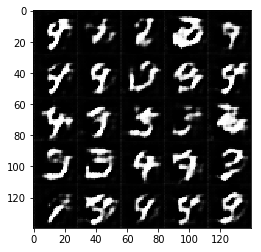

Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 0.8988
Epoch 1/2... Discriminator Loss: 1.2461... Generator Loss: 0.8127
Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 0.6049
Epoch 1/2... Discriminator Loss: 2.3534... Generator Loss: 0.1642
Epoch 1/2... Discriminator Loss: 1.3073... Generator Loss: 0.6128
Epoch 1/2... Discriminator Loss: 1.2856... Generator Loss: 1.5160
Epoch 1/2... Discriminator Loss: 1.7090... Generator Loss: 2.4157
Epoch 1/2... Discriminator Loss: 1.1216... Generator Loss: 0.8745
Epoch 1/2... Discriminator Loss: 1.1161... Generator Loss: 0.8666
Epoch 1/2... Discriminator Loss: 1.1726... Generator Loss: 0.8526


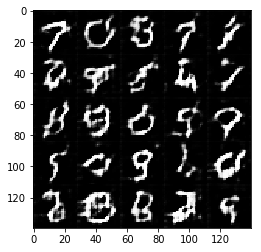

Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 1.3716
Epoch 1/2... Discriminator Loss: 1.4009... Generator Loss: 0.6975
Epoch 1/2... Discriminator Loss: 1.0936... Generator Loss: 0.9377
Epoch 1/2... Discriminator Loss: 1.2794... Generator Loss: 0.7706
Epoch 1/2... Discriminator Loss: 1.1557... Generator Loss: 0.7233
Epoch 1/2... Discriminator Loss: 1.0381... Generator Loss: 1.1061
Epoch 1/2... Discriminator Loss: 1.0198... Generator Loss: 1.5268
Epoch 1/2... Discriminator Loss: 1.1103... Generator Loss: 0.8037
Epoch 1/2... Discriminator Loss: 0.9313... Generator Loss: 1.1152
Epoch 1/2... Discriminator Loss: 1.7654... Generator Loss: 0.3551


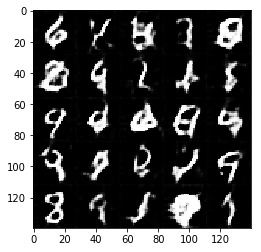

Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 0.8508
Epoch 1/2... Discriminator Loss: 1.4543... Generator Loss: 0.4882
Epoch 1/2... Discriminator Loss: 1.2346... Generator Loss: 0.6341
Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 0.7383
Epoch 1/2... Discriminator Loss: 0.9840... Generator Loss: 0.9856
Epoch 1/2... Discriminator Loss: 1.1542... Generator Loss: 1.9482
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.6068
Epoch 1/2... Discriminator Loss: 0.8127... Generator Loss: 1.2151
Epoch 1/2... Discriminator Loss: 1.1606... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 0.6782


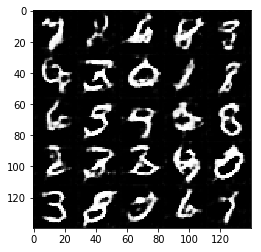

Epoch 1/2... Discriminator Loss: 0.9677... Generator Loss: 1.1086
Epoch 1/2... Discriminator Loss: 0.9104... Generator Loss: 1.0732
Epoch 1/2... Discriminator Loss: 0.9404... Generator Loss: 1.2159
Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 0.6926
Epoch 1/2... Discriminator Loss: 1.5684... Generator Loss: 0.4084
Epoch 1/2... Discriminator Loss: 1.0745... Generator Loss: 1.0699
Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 0.5406
Epoch 1/2... Discriminator Loss: 1.2636... Generator Loss: 0.5978
Epoch 1/2... Discriminator Loss: 1.6298... Generator Loss: 0.3779
Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 0.7404


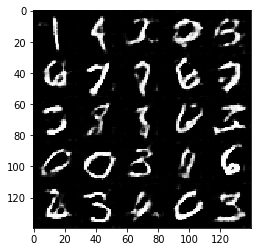

Epoch 1/2... Discriminator Loss: 1.1565... Generator Loss: 1.0853
Epoch 1/2... Discriminator Loss: 1.0651... Generator Loss: 0.9365
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 0.6307
Epoch 1/2... Discriminator Loss: 0.9510... Generator Loss: 0.8679
Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 0.5915
Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.6832
Epoch 1/2... Discriminator Loss: 0.9999... Generator Loss: 1.8112
Epoch 1/2... Discriminator Loss: 0.8253... Generator Loss: 2.2396
Epoch 1/2... Discriminator Loss: 1.2387... Generator Loss: 0.5664
Epoch 1/2... Discriminator Loss: 0.9429... Generator Loss: 1.0543


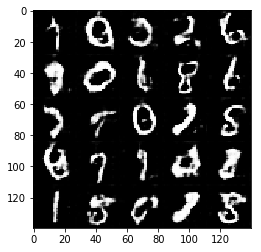

Epoch 1/2... Discriminator Loss: 1.1440... Generator Loss: 0.6846
Epoch 1/2... Discriminator Loss: 1.7064... Generator Loss: 0.3415
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 0.5084
Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 0.6429
Epoch 1/2... Discriminator Loss: 1.5063... Generator Loss: 0.5431
Epoch 1/2... Discriminator Loss: 1.4196... Generator Loss: 0.5046
Epoch 1/2... Discriminator Loss: 1.1721... Generator Loss: 0.8753
Epoch 1/2... Discriminator Loss: 1.5332... Generator Loss: 0.4130
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.6635
Epoch 1/2... Discriminator Loss: 1.2311... Generator Loss: 0.6938


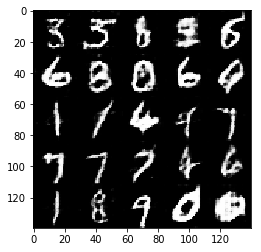

Epoch 1/2... Discriminator Loss: 1.0839... Generator Loss: 0.7638
Epoch 1/2... Discriminator Loss: 1.0713... Generator Loss: 1.1504
Epoch 1/2... Discriminator Loss: 1.0697... Generator Loss: 1.0123
Epoch 1/2... Discriminator Loss: 2.0343... Generator Loss: 0.4611
Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 0.8417
Epoch 1/2... Discriminator Loss: 1.6265... Generator Loss: 0.3909
Epoch 1/2... Discriminator Loss: 1.4575... Generator Loss: 0.5148
Epoch 1/2... Discriminator Loss: 1.4735... Generator Loss: 1.3812
Epoch 1/2... Discriminator Loss: 1.5109... Generator Loss: 0.4411
Epoch 1/2... Discriminator Loss: 1.0732... Generator Loss: 1.3165


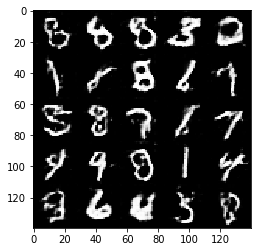

Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.5547
Epoch 1/2... Discriminator Loss: 1.0170... Generator Loss: 1.1607
Epoch 1/2... Discriminator Loss: 1.5704... Generator Loss: 0.4014
Epoch 2/2... Discriminator Loss: 0.9653... Generator Loss: 0.8381
Epoch 2/2... Discriminator Loss: 1.3409... Generator Loss: 0.5616
Epoch 2/2... Discriminator Loss: 0.8691... Generator Loss: 1.0811
Epoch 2/2... Discriminator Loss: 1.1804... Generator Loss: 0.7345
Epoch 2/2... Discriminator Loss: 1.1148... Generator Loss: 0.8061
Epoch 2/2... Discriminator Loss: 1.2426... Generator Loss: 0.6017
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.1990


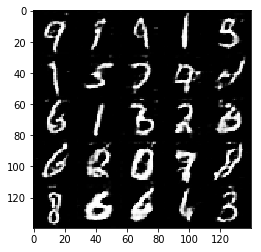

Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 0.6433
Epoch 2/2... Discriminator Loss: 1.1212... Generator Loss: 0.7697
Epoch 2/2... Discriminator Loss: 1.4303... Generator Loss: 0.4525
Epoch 2/2... Discriminator Loss: 1.6561... Generator Loss: 0.3905
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 0.5260
Epoch 2/2... Discriminator Loss: 1.8787... Generator Loss: 0.2648
Epoch 2/2... Discriminator Loss: 1.6490... Generator Loss: 0.3614
Epoch 2/2... Discriminator Loss: 1.1142... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 1.3167... Generator Loss: 0.6622
Epoch 2/2... Discriminator Loss: 1.0790... Generator Loss: 0.8146


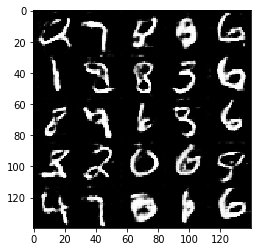

Epoch 2/2... Discriminator Loss: 1.2304... Generator Loss: 0.6672
Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 0.6267
Epoch 2/2... Discriminator Loss: 2.3653... Generator Loss: 0.1659
Epoch 2/2... Discriminator Loss: 1.4075... Generator Loss: 0.5212
Epoch 2/2... Discriminator Loss: 2.4389... Generator Loss: 0.1641
Epoch 2/2... Discriminator Loss: 0.9157... Generator Loss: 1.0634
Epoch 2/2... Discriminator Loss: 1.1031... Generator Loss: 0.7279
Epoch 2/2... Discriminator Loss: 1.7611... Generator Loss: 0.3235
Epoch 2/2... Discriminator Loss: 1.7991... Generator Loss: 0.3631
Epoch 2/2... Discriminator Loss: 1.3176... Generator Loss: 0.5644


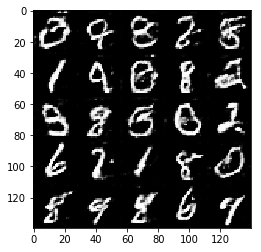

Epoch 2/2... Discriminator Loss: 1.4192... Generator Loss: 0.6012
Epoch 2/2... Discriminator Loss: 1.6010... Generator Loss: 0.3831
Epoch 2/2... Discriminator Loss: 2.1016... Generator Loss: 0.2396
Epoch 2/2... Discriminator Loss: 0.9832... Generator Loss: 0.9723
Epoch 2/2... Discriminator Loss: 2.5121... Generator Loss: 0.1734
Epoch 2/2... Discriminator Loss: 0.8123... Generator Loss: 1.1509
Epoch 2/2... Discriminator Loss: 0.9333... Generator Loss: 1.1510
Epoch 2/2... Discriminator Loss: 1.8169... Generator Loss: 0.3020
Epoch 2/2... Discriminator Loss: 1.6509... Generator Loss: 0.3894
Epoch 2/2... Discriminator Loss: 0.8703... Generator Loss: 1.0516


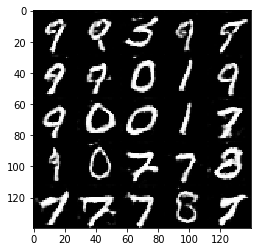

Epoch 2/2... Discriminator Loss: 2.6135... Generator Loss: 0.1408
Epoch 2/2... Discriminator Loss: 1.1002... Generator Loss: 1.6277
Epoch 2/2... Discriminator Loss: 1.2391... Generator Loss: 0.5868
Epoch 2/2... Discriminator Loss: 0.9946... Generator Loss: 1.7978
Epoch 2/2... Discriminator Loss: 1.0897... Generator Loss: 0.9509
Epoch 2/2... Discriminator Loss: 1.9341... Generator Loss: 0.2590
Epoch 2/2... Discriminator Loss: 2.2341... Generator Loss: 0.2020
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 3.3587
Epoch 2/2... Discriminator Loss: 2.0515... Generator Loss: 0.2507
Epoch 2/2... Discriminator Loss: 1.5973... Generator Loss: 0.5160


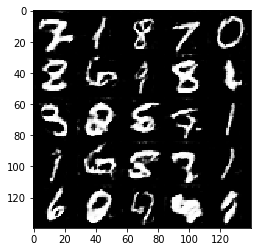

Epoch 2/2... Discriminator Loss: 1.1826... Generator Loss: 1.1208
Epoch 2/2... Discriminator Loss: 1.3229... Generator Loss: 0.5511
Epoch 2/2... Discriminator Loss: 1.7015... Generator Loss: 0.3301
Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 0.7702
Epoch 2/2... Discriminator Loss: 1.1002... Generator Loss: 0.8739
Epoch 2/2... Discriminator Loss: 1.2021... Generator Loss: 0.7064
Epoch 2/2... Discriminator Loss: 2.2017... Generator Loss: 0.2038
Epoch 2/2... Discriminator Loss: 1.3298... Generator Loss: 0.5459
Epoch 2/2... Discriminator Loss: 1.4436... Generator Loss: 0.5013
Epoch 2/2... Discriminator Loss: 1.0052... Generator Loss: 1.2628


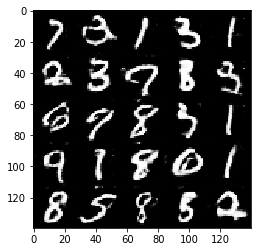

Epoch 2/2... Discriminator Loss: 1.4663... Generator Loss: 0.4443
Epoch 2/2... Discriminator Loss: 1.7413... Generator Loss: 0.3634
Epoch 2/2... Discriminator Loss: 1.0125... Generator Loss: 0.7843
Epoch 2/2... Discriminator Loss: 1.5837... Generator Loss: 0.4205
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 1.1107
Epoch 2/2... Discriminator Loss: 1.0681... Generator Loss: 0.7267
Epoch 2/2... Discriminator Loss: 1.6752... Generator Loss: 0.3541
Epoch 2/2... Discriminator Loss: 0.9977... Generator Loss: 0.9967
Epoch 2/2... Discriminator Loss: 1.1265... Generator Loss: 1.4942
Epoch 2/2... Discriminator Loss: 0.9756... Generator Loss: 1.0204


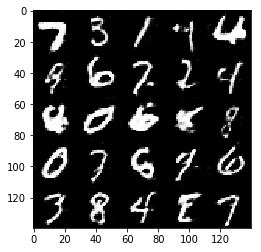

Epoch 2/2... Discriminator Loss: 1.1053... Generator Loss: 1.1728
Epoch 2/2... Discriminator Loss: 1.7966... Generator Loss: 0.3230
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 0.5606
Epoch 2/2... Discriminator Loss: 1.6495... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 2.1053... Generator Loss: 0.2048
Epoch 2/2... Discriminator Loss: 0.8856... Generator Loss: 1.1450
Epoch 2/2... Discriminator Loss: 1.5794... Generator Loss: 0.4255
Epoch 2/2... Discriminator Loss: 2.1888... Generator Loss: 0.2222
Epoch 2/2... Discriminator Loss: 2.3038... Generator Loss: 0.1737
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.5005


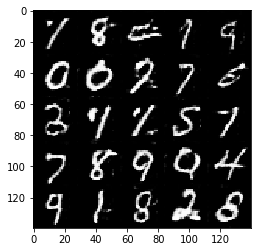

Epoch 2/2... Discriminator Loss: 1.7427... Generator Loss: 0.3523
Epoch 2/2... Discriminator Loss: 1.4161... Generator Loss: 0.4553
Epoch 2/2... Discriminator Loss: 0.8400... Generator Loss: 1.3240
Epoch 2/2... Discriminator Loss: 2.4036... Generator Loss: 0.1667
Epoch 2/2... Discriminator Loss: 0.8517... Generator Loss: 1.2841
Epoch 2/2... Discriminator Loss: 1.2804... Generator Loss: 0.5648
Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 2.2435
Epoch 2/2... Discriminator Loss: 2.5776... Generator Loss: 0.1531
Epoch 2/2... Discriminator Loss: 1.1213... Generator Loss: 1.0749
Epoch 2/2... Discriminator Loss: 1.7271... Generator Loss: 0.3162


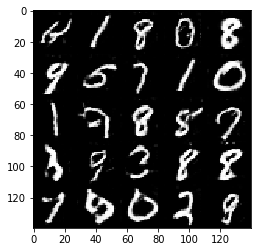

Epoch 2/2... Discriminator Loss: 1.1335... Generator Loss: 0.7929
Epoch 2/2... Discriminator Loss: 1.2954... Generator Loss: 0.6352
Epoch 2/2... Discriminator Loss: 2.3424... Generator Loss: 0.1730
Epoch 2/2... Discriminator Loss: 1.2398... Generator Loss: 0.5870
Epoch 2/2... Discriminator Loss: 0.8331... Generator Loss: 1.0171
Epoch 2/2... Discriminator Loss: 1.6370... Generator Loss: 0.3614
Epoch 2/2... Discriminator Loss: 1.5298... Generator Loss: 0.4207


In [16]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 1.9985
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 4.5509
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 2.0881
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 1.2498
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 1.3600


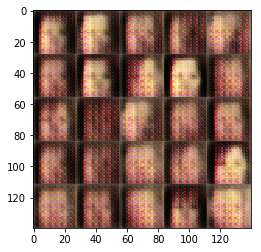

Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.8646
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.4617
Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 1.6421
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.2086
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 1.0734
Epoch 1/1... Discriminator Loss: 0.8381... Generator Loss: 1.2250
Epoch 1/1... Discriminator Loss: 1.8309... Generator Loss: 2.3031


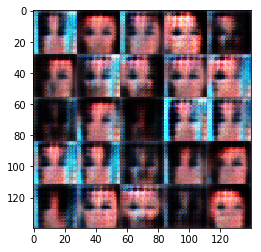

Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 1.1107
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 1.2583
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 1.7321
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 0.8641... Generator Loss: 2.3564
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.5534
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 3.2632... Generator Loss: 4.1956


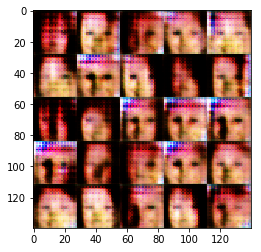

Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 2.8502
Epoch 1/1... Discriminator Loss: 0.7738... Generator Loss: 1.4894
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 1.1981
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 2.0016


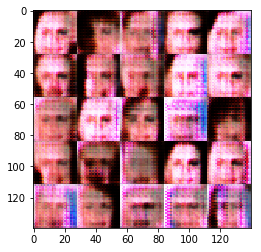

Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 1.2914
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 1.1772
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 1.4962
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 2.2323
Epoch 1/1... Discriminator Loss: 0.8088... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 1.2888
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.6346


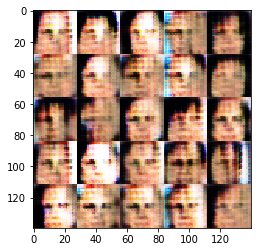

Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.5228
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 1.8784
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.4427
Epoch 1/1... Discriminator Loss: 0.7523... Generator Loss: 1.4338
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.6640
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 0.8010


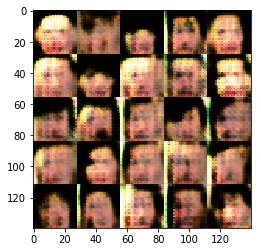

Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 1.5876
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 1.9829
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 1.5455
Epoch 1/1... Discriminator Loss: 0.5917... Generator Loss: 2.0447
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.4696
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 0.7413... Generator Loss: 1.6357


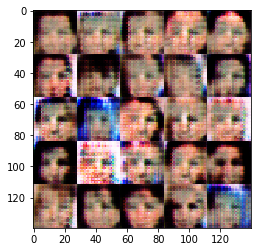

Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 1.7237
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 3.7967
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.9953
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 2.0567
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 1.5971
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.5640


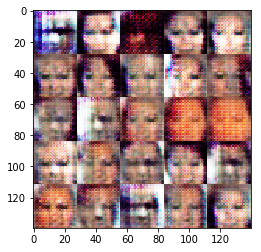

Epoch 1/1... Discriminator Loss: 1.9742... Generator Loss: 0.2431
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.6968
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 2.9359
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 0.6750... Generator Loss: 1.6464
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.3823


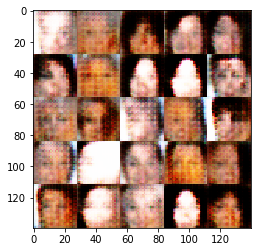

Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 1.7820
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.7641
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 1.6206
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.1699
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 1.1614
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 0.9664


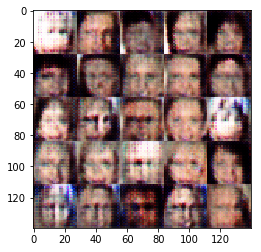

Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 2.0459
Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 1.1930
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 3.4932
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 1.6514
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 2.6801
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.4294
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 2.2544
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 1.9490


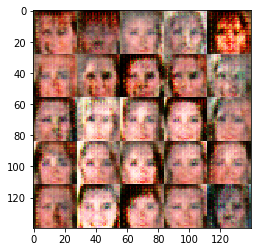

Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 1.0888
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 2.1209
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.3455
Epoch 1/1... Discriminator Loss: 1.6207... Generator Loss: 0.3729
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 3.1870
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.3510
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 2.6955
Epoch 1/1... Discriminator Loss: 1.7409... Generator Loss: 0.3369


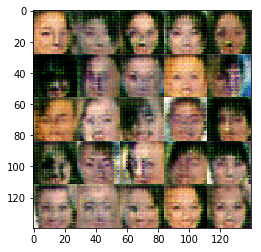

Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 1.9395
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 1.4380
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.4542
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 1.3735
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 2.1383
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 1.4997
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 0.8755


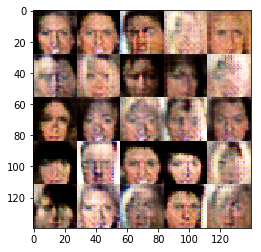

Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 1.2265
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.2508
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 1.5239
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 1.2724
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.4858


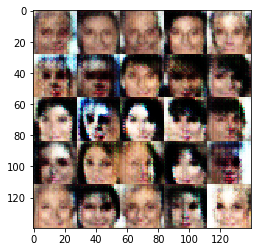

Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.3380
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 1.2442
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 2.4087
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.1024
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 0.8495


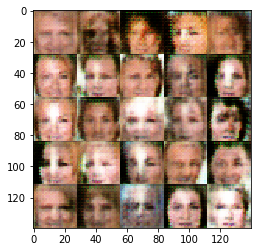

Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 1.3296
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.1538
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 1.2363


In [18]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.